In [7]:
import numpy as np
import pandas as pd

import tensorflow as tf

Paper Link https://arxiv.org/abs/1809.10410

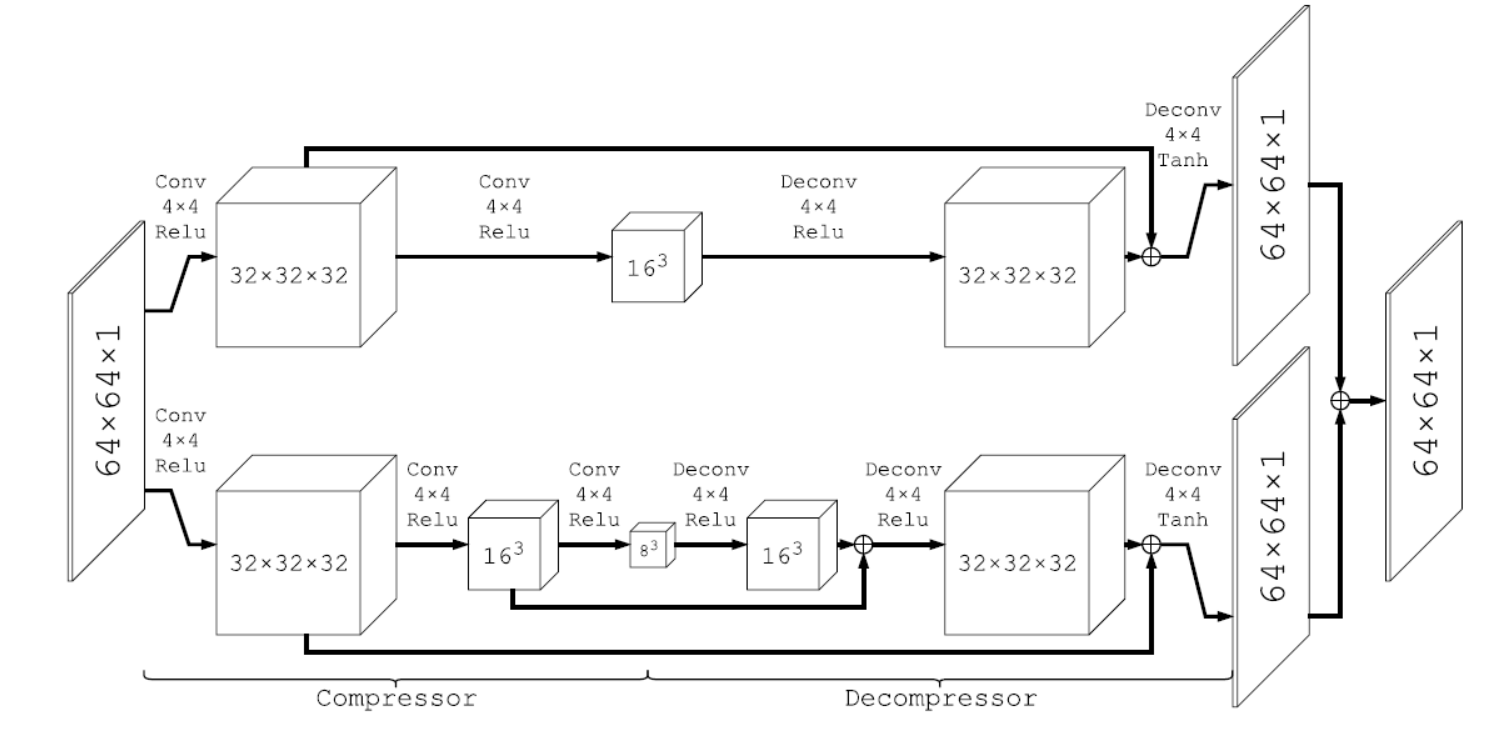

In [8]:
# Download the mnist dataset using keras
data_train, data_test = tf.keras.datasets.mnist.load_data()

# Parse images and labels
(images_train, labels_train) = data_train
(images_test, labels_test) = data_test

def prepare_batch(Data, Label, batch_size):
    batch_indice = np.random.randint(0, Data.shape[0], batch_size)
    batch_datas = np.array([Data[index] for index in batch_indice]) 
    batch_labels = np.array([Label[index] for index in batch_indice])
    return batch_datas, batch_labels

In [9]:
tf.reset_default_graph()

In [10]:
height = 28
width = 28
std = 100
learning_rate = 0.001

X = tf.placeholder(tf.float32, shape = [None, height, width], name = "X")
noise = tf.truncated_normal(shape=tf.shape(X), mean=0.0, stddev=std, dtype=tf.float32)
noised_data = tf.scalar_mul(0.8, X+noise)
noise_X = tf.reshape(noised_data, shape=[-1, height, width, 1]) # gray scale
reshaped_X = tf.reshape(X, shape=[-1, height, width, 1])

In [11]:
with tf.name_scope("Compress_first"):
    conv1 = tf.layers.conv2d(noise_X, filters = 32,
                            kernel_size = 4, strides = 1,
                            padding = "SAME", name ="C1_conv1")
    conv1_act = tf.nn.relu(conv1, name = "C1_conv1_act")
    
    conv2 = tf.layers.conv2d(conv1_act, filters = 16,
                            kernel_size = 2, strides = 2,
                            padding = "SAME", name ="C1_conv2")
    conv2_act = tf.nn.relu(conv2, name = "C1_conv2_act")
    
    conv3 = tf.layers.conv2d(conv2_act, filters = 8,
                            kernel_size = 1, strides = 1,
                            padding = "SAME", name ="C1_conv3")
    conv3_act = tf.nn.relu(conv3, name = "C1_conv3_act")
    
    deconv1 = tf.layers.conv2d_transpose(conv3_act, filters = 16,
                                    kernel_size = 2, strides = 1,
                                    padding = "same", name = "C1_dconv1")
    
    deconv1_act = tf.nn.relu(deconv1, name = "C1_dconv1_act")
    
    sum_after_deconv1 = conv2_act + deconv1_act
    
    deconv2 =tf.layers.conv2d_transpose(sum_after_deconv1, filters = 32,
                                    kernel_size = 4, strides = 2,
                                    padding = "SAME", name = "C1_dconv2")
    
    deconv2_act = tf.nn.relu(deconv2, name = "C1_dconv2_act")
    
    sum_after_deconv2 = conv1_act + deconv2_act
    
    last_act = tf.nn.tanh(sum_after_deconv2, name = "C1_fianl")

W0713 15:50:20.024779 139967461549888 deprecation.py:323] From <ipython-input-11-f54183bcf010>:4: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0713 15:50:20.032372 139967461549888 deprecation.py:506] From /home/jinhokim/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0713 15:50:20.152271 139967461549888 deprecation.py:323] From <ipython-input-11-f54183bcf010>:19: conv2d_transpose (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.


In [12]:
with tf.name_scope("Compress_second"):
    con2v1 = tf.layers.conv2d(noise_X, filters = 32,
                            kernel_size = 4, strides = 1,
                            padding = "SAME", name ="C2_conv1")
    con2v1_act = tf.nn.relu(con2v1, name = "C1_conv1_act")
    
    con2v2 = tf.layers.conv2d(con2v1_act, filters = 16,
                            kernel_size = 2, strides = 2,
                            padding = "SAME", name ="C2_conv2")
    con2v2_act = tf.nn.relu(con2v2, name = "C2_conv2_act")
    
    decon2v1 = tf.layers.conv2d_transpose(con2v2_act, filters = 32,
                                    kernel_size = 2, strides = 2,
                                    padding = "same", name = "C2_dconv1")
    
    decon2v1_act = tf.nn.relu(decon2v1, name = "C2_dconv1_act")
    
    sum_after_decon2v1 = con2v1_act + decon2v1_act
    
    last2_act = tf.nn.tanh(sum_after_decon2v1, name = "C2_fianl")

In [13]:
with tf.name_scope("Last_Layer"):
    final_layer = tf.layers.flatten(last_act + last2_act)
    logits = tf.layers.dense(final_layer, height*width, activation =None)

W0713 15:50:20.575071 139967461549888 deprecation.py:323] From <ipython-input-13-a49fda2e9d45>:2: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0713 15:50:20.704533 139967461549888 deprecation.py:323] From <ipython-input-13-a49fda2e9d45>:3: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


In [14]:
with tf.name_scope("train"):
    X_for_compare = tf.layers.flatten(X)
    calculate = tf.losses.mean_squared_error(X_for_compare, logits)
    loss = tf.reduce_mean(calculate, name='loss')
    optimizer = tf.train.AdamOptimizer(learning_rate, name="compress_adam") 
    training_op = optimizer.minimize(loss, name="compress_training_op")

W0713 15:50:20.852210 139967461549888 deprecation.py:323] From /home/jinhokim/.local/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

config = tf.ConfigProto() 
config.gpu_options.allow_growth = True 

In [ ]:
n_epochs = 21
batch_size = 100

with tf.Session(config=config) as sess:
    init.run() 
    
    for epoch in range(n_epochs):
        for iteration in range(len(images_train) // batch_size):        
            X_batch, _ = prepare_batch(images_train, labels_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        
        noise_image = sess.run([noise_X], feed_dict={X: X_batch})

        for op in (X, logits, noise_X):
            tf.add_to_collection("my_important_ops", op)
        save_path = saver.save(sess, "./TF_MODEL/Consturct/vanilla")
        
        X_batch, _ = prepare_batch(images_train, labels_train, batch_size)
        loss_train = loss.eval(feed_dict={X: X_batch})
        
        X_test_batch, _ = prepare_batch(images_test, labels_test, batch_size)
        loss_test = loss.eval(feed_dict={X: X_test_batch}) 
        
        if (epoch % 5 == 0):
            print(epoch, "Train Loss:", loss_train, "Test Loss:", loss_test)

In [11]:
weight_path = "./TF_MODEL/Consturct/vanilla.meta"
checkp_path = "./TF_MODEL/Consturct/"

In [12]:
new_saver = tf.train.import_meta_graph(weight_path)
DAE_X, DAE_outputs, DAE_noise = tf.get_collection("my_important_ops")[:3]

In [13]:
with tf.Session(config = config) as sess:
    init.run()
    new_saver.restore(sess, tf.train.latest_checkpoint(checkp_path))
    for epoch in range(n_epochs):
        X_test_batch, _ = prepare_batch(images_test,labels_test,100)
        y_sample, noise_image = sess.run([DAE_outputs, DAE_noise], feed_dict={DAE_X: X_test_batch})

W0713 02:03:04.265585 140344057636672 deprecation.py:323] From /home/jinhokim/.local/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


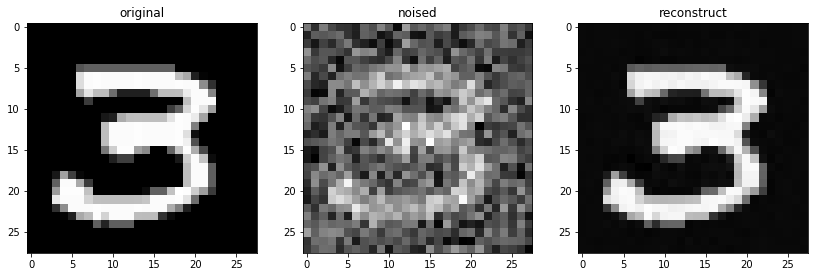

In [16]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,7))

num = 20

ax1 = fig.add_subplot(131)
ax1.imshow(X_test_batch[num].reshape(28,28), cmap="gray")
ax1.set_title("original")

ax2 = fig.add_subplot(132)
ax2.imshow(noise_image[num].reshape(28,28), cmap="gray")
ax2.set_title("noised")

ax3 = fig.add_subplot(133)
ax3.imshow(y_sample[num].reshape(28,28), cmap="gray")
ax3.set_title("reconstruct")

plt.show()

In [15]:
np.mean(X_test_batch[num].flatten()-y_sample[num])

-0.61184263